In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_hub as hub

warnings.filterwarnings("ignore")

#**Load data**

In [2]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [3]:
# Data
sentence = "my name is eder"
words = sentence.split()

input_dim = 512
sequence_length = len(words)
d_model = 512
batch_size = 1

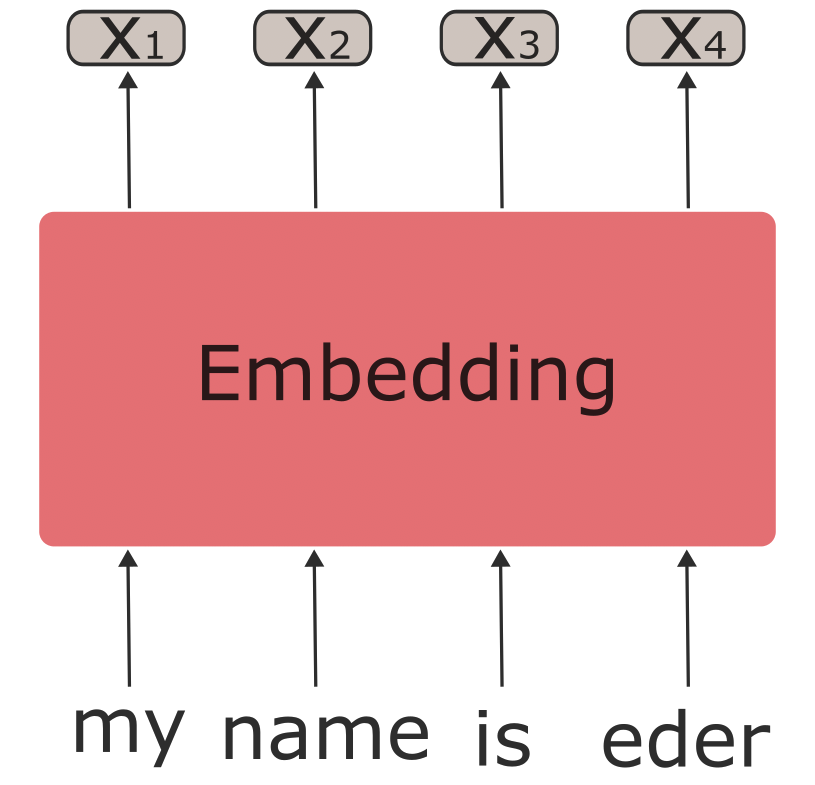

In [4]:
word_vectors = np.zeros((sequence_length, input_dim)) 
X = tf.zeros([1, sequence_length, input_dim], dtype=tf.float32)

for word, i in zip(words, range(sequence_length)):
  word_vector = embed([word])
  index = tf.constant([[0, 2]])
  X = tf.tensor_scatter_nd_update(X, index, word_vector)

  word_vectors[i,:] = word_vector.numpy()

X.shape

TensorShape([1, 4, 512])

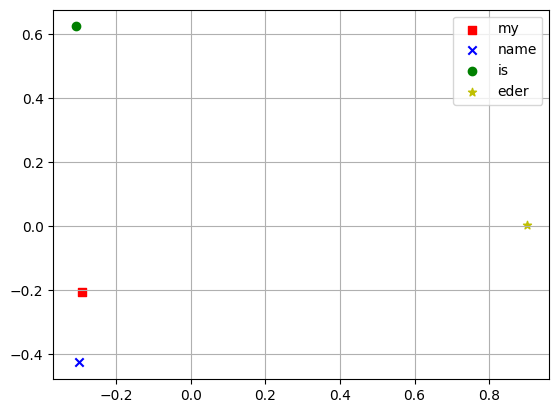

In [5]:
colors = ['r', 'b', 'g', 'y']
markers = ['s', 'x', 'o', '*']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(word_vectors)

for l, c, m in zip(range(len(X_pca)), colors, markers):
  plt.scatter(X_pca[l, 0], X_pca[l, 1], c=c, label=words[l], marker=m)
plt.legend()
plt.grid()
plt.show()

Remember:

$$ y = xA^{\top}+b$$

In [6]:
qkv_layer = tf.keras.layers.Dense(3*d_model, input_shape=(input_dim,))

In [7]:
qkv = qkv_layer(X)

qkv.shape

TensorShape([1, 4, 1536])

In [8]:
num_heads = 8
head_dim = d_model // num_heads

batch_size, sequence_length, num_heads, 3 * head_dim
qkv = tf.reshape(qkv, [batch_size, sequence_length, num_heads, 3*head_dim])

qkv.shape

TensorShape([1, 4, 8, 192])

In [9]:
qkv.shape

TensorShape([1, 4, 8, 192])

*   1: text
*   4: sequence number (words)
*   6: attention heads
*   150: attention head size 


In [10]:
# batch_size, num_heads, sequence_length, 3*head_dim
qkv = tf.transpose(qkv, perm=[0, 2, 1, 3])

qkv.shape

TensorShape([1, 8, 4, 192])

Tensor query, keys, and values

In [11]:
Q, K, V = tf.split(qkv, num_or_size_splits=3, axis=-1)
Q.shape, K.shape, V.shape

(TensorShape([1, 8, 4, 64]),
 TensorShape([1, 8, 4, 64]),
 TensorShape([1, 8, 4, 64]))

#**Multi-Head Attention**

Remember:

\begin{align}
  \textbf{H} = softmax \left( \frac{\textbf{Q} \textbf{K}^\top }{\sqrt{d_k}} \right) \textbf{V} 
\end{align}

\begin{align}
  \textbf{H} = \textbf{A} \textbf{V} 
\end{align}


In [12]:
print("Dimension of K: ", K.shape)
print("Dimension of transpose to all the vector: ", tf.transpose(K).shape)
print("Dimension of transpose of only K: ", tf.transpose(K, perm=[0, 1, 3, 2]).shape)

Dimension of K:  (1, 8, 4, 64)
Dimension of transpose to all the vector:  (64, 4, 8, 1)
Dimension of transpose of only K:  (1, 8, 64, 4)


In [13]:
Q.shape

TensorShape([1, 8, 4, 64])

In [14]:
d_k = Q.shape[-1]
d_k = tf.cast(d_k, dtype=tf.float32)
dot_softmax = tf.matmul(Q, tf.transpose(K, perm=[0, 1, 3, 2])) / tf.math.sqrt(d_k)

dot_softmax.shape

TensorShape([1, 8, 4, 4])

Mask

In [15]:
mask = tf.fill(dot_softmax.shape, tf.constant(float('-inf')))
mask = tf.linalg.band_part(mask, num_lower=0, num_upper=-1)
mask = tf.linalg.set_diag(mask, tf.zeros(mask.shape[:-1]))

mask[0][1]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]], dtype=float32)>

In [16]:
dot_softmax.shape

TensorShape([1, 8, 4, 4])

In [17]:
(dot_softmax + mask)[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        ,       -inf,       -inf,       -inf],
       [0.        , 0.        ,       -inf,       -inf],
       [0.        , 0.        , 0.00017965,       -inf],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)>

In [18]:
dot_softmax = dot_softmax + mask

In [19]:
A = tf.nn.softmax(dot_softmax, axis=-1)
A.shape

TensorShape([1, 8, 4, 4])

In [20]:
A[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.99999994, 0.        , 0.        , 0.        ],
       [0.49999997, 0.49999997, 0.        , 0.        ],
       [0.33331338, 0.33331338, 0.33337328, 0.        ],
       [0.24999999, 0.24999999, 0.24999999, 0.24999999]], dtype=float32)>

In [21]:
H = tf.matmul(A, V)
H.shape

TensorShape([1, 8, 4, 64])

In [22]:
A[0][0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.99999994, 0.        , 0.        , 0.        ],
       [0.49999997, 0.49999997, 0.        , 0.        ],
       [0.33331338, 0.33331338, 0.33337328, 0.        ],
       [0.24999999, 0.24999999, 0.24999999, 0.24999999]], dtype=float32)>

In [23]:
def scaled_dot_product_attention(Q, K, V, mask=None):
  
  d_k = Q.shape[-1]
  dot_softmax = tf.matmul(Q, K, transpose_b=True) / math.sqrt(d_k)

  if mask is not None:
    dot_softmax = dot_softmax + mask

  A = tf.nn.softmax(dot_softmax, axis=-1)
  H = tf.matmul(A, V)
  
  return H, A

In [24]:
H, A = scaled_dot_product_attention(Q, K, V, mask=mask)

H.shape, A.shape

(TensorShape([1, 8, 4, 64]), TensorShape([1, 8, 4, 4]))

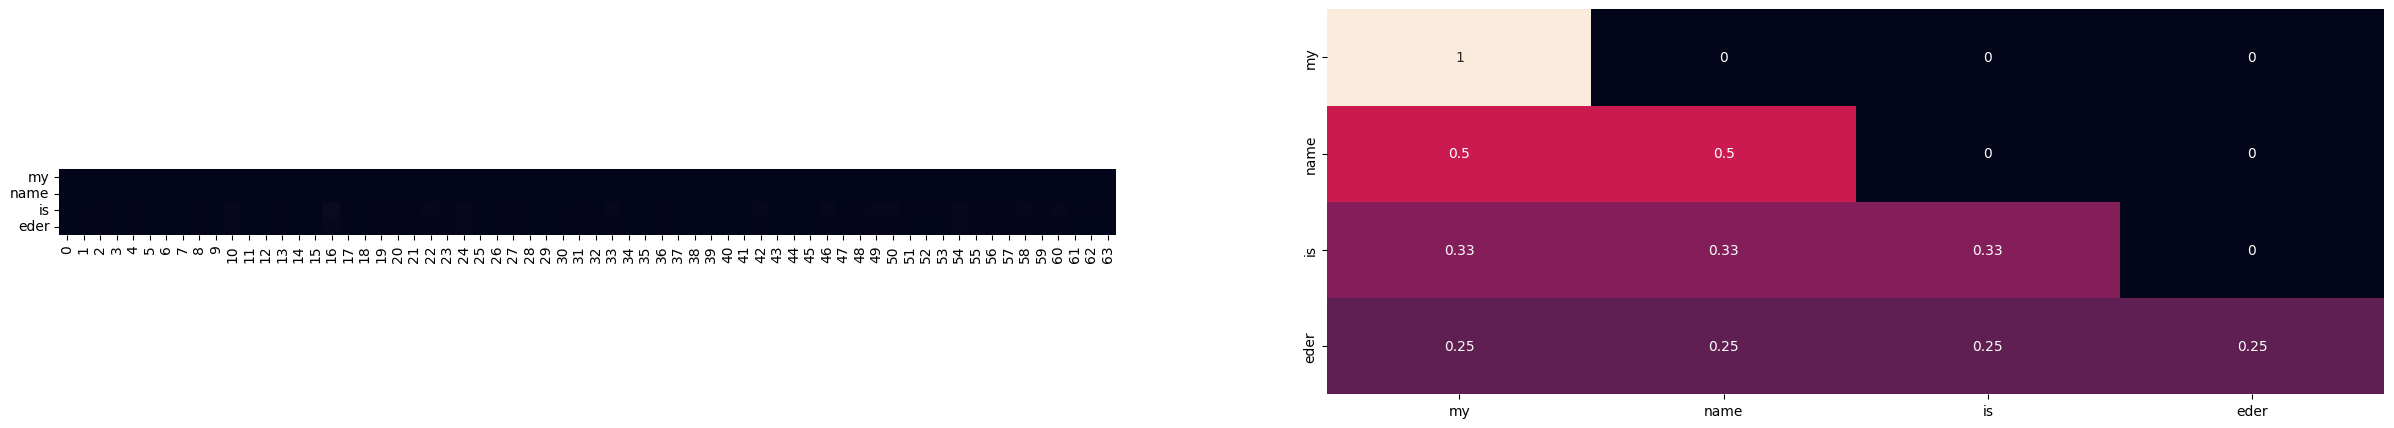

In [31]:
plt.figure(figsize=(30,5))
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(H[0][0].numpy(), cbar=0, vmax=1, vmin=0, yticklabels=words, square=True)
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(A[0][0].numpy(), cbar=0, vmax=1, vmin=0, xticklabels=words, yticklabels=words, annot=True)
plt.show()

In [26]:
words

['my', 'name', 'is', 'eder']